# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git)

GIT is, at the moment of writing, a state-of-the-art image/video captioning

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 14.6 MB/s eta 0:00:00


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 18.6 MB/s eta 0:00:00


In [ ]:
ls

drive/  sample_data/


In [ ]:
cd /content/drive/MyDrive/Upwork/imageCaptioning/images

[Errno 2] No such file or directory: '/content/drive/MyDrive/Upwork/imageCaptioning/images'
/content


## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

In [ ]:
import json

captions = [{"file_name": "ronaldo.jpeg", "text": "Ronaldo with Portugal at the 2018 World Cup"},
{"file_name": "messi.jpeg", "text": "Messi with Argentina at the 2022 FIFA World Cup"},
{"file_name": "zidane.jpeg", "text": "Zinédine Zidane pendant la finale de la Coupe du monde 2006."},
{"file_name": "maradona.jpeg", "text": "Maradona after winning the 1986 FIFA World Cup with Argentina"},
{"file_name": "ronaldo_.jpeg", "text": "Ronaldo won La Liga in his first season and received the Pichichi Trophy in his second."},
{"file_name": "pirlo.jpeg", "text": "Pirlo with Juventus in 2014"},]

# path to the folder containing the images
root = "/content/drive/MyDrive/Upwork/imageCaptioning/data"

# add metadata.jsonl file to this folder
with open(root + "/metadata.jsonl", 'w') as f:
    for item in captions:
        f.write(json.dumps(item) + "\n")

Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

In [ ]:
from datasets import load_dataset 

dataset = load_dataset("imagefolder", data_dir=root, split="train")

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-8bb8538997726258/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


Let's check whether the dataset is created correctly:

In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 6
})

Let's take a look at one example:

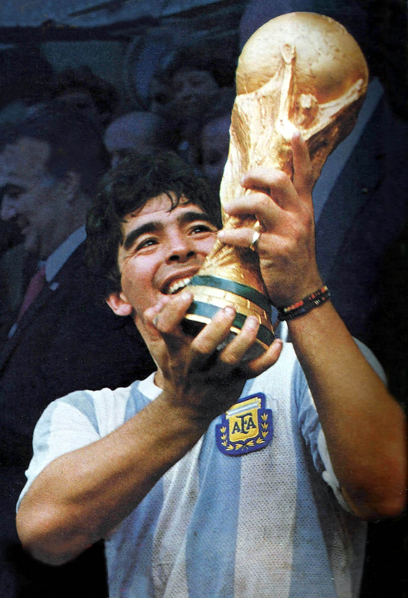

In [ ]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Let's check its corresponding caption:

In [ ]:
example["text"]

'Maradona after winning the 1986 FIFA World Cup with Argentina'

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values. 

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [ ]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [ ]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [ ]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [ ]:
processor.decode(batch["input_ids"][0])

'[CLS] ronaldo with portugal at the 2018 world cup [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

We can "denormalize" the pixel values to get back an image:

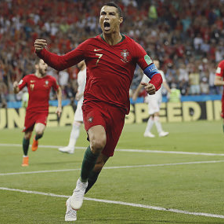

In [ ]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [ ]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.0503, grad_fn=<NllLossBackward0>)

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 12.454559326171875
Loss: 10.75849437713623
Loss: 10.207998275756836
Epoch: 1
Loss: 9.912622451782227
Loss: 9.675827980041504
Loss: 9.493936538696289
Epoch: 2
Loss: 9.243614196777344
Loss: 9.108003616333008
Loss: 8.908135414123535
Epoch: 3
Loss: 8.773813247680664
Loss: 8.607172966003418
Loss: 8.457080841064453
Epoch: 4
Loss: 8.343048095703125
Loss: 8.229371070861816
Loss: 8.121312141418457
Epoch: 5
Loss: 7.9738264083862305
Loss: 7.918354511260986
Loss: 7.7941460609436035
Epoch: 6
Loss: 7.645436763763428
Loss: 7.585696220397949
Loss: 7.504135608673096
Epoch: 7
Loss: 7.342489242553711
Loss: 7.292893886566162
Loss: 7.161111354827881
Epoch: 8
Loss: 7.085412502288818
Loss: 6.966336727142334
Loss: 6.8202362060546875
Epoch: 9
Loss: 6.7041730880737305
Loss: 6.6831536293029785
Loss: 6.515305995941162
Epoch: 10
Loss: 6.381066799163818
Loss: 6.356971740722656
Loss: 6.19642448425293
Epoch: 11
Loss: 6.084834098815918
Loss: 6.019604682922363
Loss: 5.861243724822998
Epoch: 12
Loss: 5.75

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

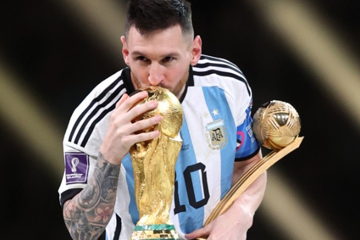

In [ ]:
# load image
example = dataset[1]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [ ]:
from PIL import Image
im = Image.open("/content/drive/MyDrive/Upwork/imageCaptioning/test/messi_test.jpeg")

In [ ]:
# prepare image for the model
inputs = processor(images=im, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

messi with argentina at the 2022 fifa world cup


Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of football players.